In [80]:
from selenium import webdriver
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup
import re
import time
from datetime import date, datetime, timedelta
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.linalg import cholesky
from scipy import stats
import random
import pulp
from pulp import *
import statsmodels.api as sm

# FIRST SCRAPE

In [2]:
driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - Current google-chrome version is 85.0.4183
[WDM] - Get LATEST driver version for 85.0.4183
[WDM] - Driver [/Users/prupes/.wdm/drivers/chromedriver/mac64/85.0.4183.87/chromedriver] found in cache


## Login into account manually

In [3]:
root = 'https://rotogrinders.com'

In [18]:
def get_base_page(date, Fanduel=False):
    if Fanduel:
        url = "https://rotogrinders.com/resultsdb/site/fanduel/date/{}/sport/nfl".format(date)
        return driver.get(url)
    else:
        url = "https://rotogrinders.com/resultsdb/site/draftkings/date/{}/sport/nfl".format(date)
        return driver.get(url)

    return df

def projections(date_string):
    output = {}
    url = 'https://rotogrinders.com/projected-stats/nfl?site=draftkings&date={}'.format(date_string)
    driver.get(url)
    time.sleep(3)
    #print('hello')
    soup=BeautifulSoup(driver.page_source,'html.parser')
    mydivs = soup.findAll("div", {"class": "rgt-col"})
    try:
        points = [float(a.text) for a in mydivs[-2].findAll("div")[1:]]
        name = [a.text for a in mydivs[0].findAll("div")[1:]]
        salary = [float(a.text[1:-1])*1000 for a in mydivs[1].findAll("div")[1:]]
        team = [a.text for a in mydivs[2].findAll("div")[1:]]
        position = [a.text for a in mydivs[3].findAll("div")[1:]]
        opp = [a.text for a in mydivs[4].findAll("div")[1:]]
        pownership = [float(a.text[:-1])/100 for a in mydivs[-10].findAll("div")[1:]]
    except:
        return False
    for i in range(len(name)):
        output[name[i]] = {'opp':opp[i], 'position': position[i], 'points':points[i],
                           'powner': pownership[i], 'salary':salary[i], 'team':team[i]}        #print(name[i], ceil[i], floor[i], points[i])
    return output
def current_projections():
    output = {}
    url = 'https://rotogrinders.com/projected-stats/nfl?site=draftkings'
    driver.get(url)
    time.sleep(3)
    #print('hello')
    soup=BeautifulSoup(driver.page_source,'html.parser')
    mydivs = soup.findAll("div", {"class": "rgt-col"})
    try:
        points = [float(a.text) for a in mydivs[-2].findAll("div")[1:]]
        name = [a.text for a in mydivs[0].findAll("div")[1:]]
        salary = [float(a.text[1:-1])*1000 for a in mydivs[1].findAll("div")[1:]]
        team = [a.text for a in mydivs[2].findAll("div")[1:]]
        position = [a.text for a in mydivs[3].findAll("div")[1:]]
        opp = [a.text for a in mydivs[4].findAll("div")[1:]]
        #to fix later
        #pownership = [float(a.text[:-1])/100 for a in mydivs[-10].findAll("div")[1:]]
    except:
        return False
    for i in range(len(name)):
        output[name[i]] = {'opp':opp[i], 'position': position[i], 'points':points[i],
                           'salary':salary[i], 'team':team[i]}        #print(name[i], ceil[i], floor[i], points[i])
    return output

In [66]:
PROJECTIONS = current_projections()

## Download detailed projections from https://rotogrinders.com/lineuphq/nfl?site=draftkings&post=3350867

In [67]:
detailed_projections = pd.read_csv("../resources/current_detailed_projections.csv")

In [68]:
detailed_projections.head()

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849791,LAR,PHI,RB,Xavier Jones,0.00,NaN,NaN,NaN,0,100
1,328578,NYJ,SFO,QB,Mike White,0.00,NaN,NaN,NaN,0,100
2,982789,ARI,WAS,WR,Andy Isabella,4.36,0.1,8.68,0.39,0,100
3,37028,HOU,BAL,TE,Pharaoh Brown,0.00,NaN,NaN,NaN,0,100
4,36967,NYG,CHI,RB,Wayne Gallman Jr.,0.53,0.1,1.06,0.01,0,100


# Now clean the data

In [69]:
teams_translate_unused = {
    "Arizona Cardinals": 'ARI',
    "Atlanta Falcons": "ATL",
    'Baltimore Ravens': "BAL",
    'Buffalo Bills': 'BUF',
    'Carolina Panthers': 'CAR',
    'Chicago Bears': 'CHI',
    'Cincinnati Bengals': 'CIN',
    'Cleveland Browns': 'CLE',
    'Dallas Cowboys': 'DAL',
    'Denver Broncos': 'DEN',
    'Detroit Lions': 'DET',
    'Green Bay Packers': 'GBP',
    'Houston Texans': 'HOU',
    'Indianapolis Colts': 'IND',
    'Jacksonville Jaguars': 'JAC',
    'Kansas City Chiefs': 'KCC',
    'Las Vegas Raiders': 'LVR',
    'Los Angeles Chargers': 'LAC',
    'Los Angeles Rams': 'LAR',
    'Miami Dolphins': 'MIA',
    'Minnesota Vikings': 'MIN',
    'New England Patriots': 'NEP',
    'New Orleans Saints': 'NOS',
    'New York Giants': 'NYG',
    'New York Jets': 'NYJ',
    'Philadelphia Eagles': 'PHI',
    'Pittsburgh Steelers': 'PIT',
    'San Francisco 49ers': 'SFO',
    'Seattle Seahawks': 'SEA',
    'Tampa Bay Buccaneers': 'TBB',
    'Tennessee Titans' : 'TEN',
    'Washington Football Team': 'WAS'
}

In [70]:
teams_translate = {
    "Arizona Cardinals": 'Cardinals',
    "Atlanta Falcons": "Falcons",
    'Baltimore Ravens': "Ravens",
    'Buffalo Bills': 'Bills',
    'Carolina Panthers': 'Panthers',
    'Chicago Bears': 'Bears',
    'Cincinnati Bengals': 'Bengals',
    'Cleveland Browns': 'Browns',
    'Dallas Cowboys': 'Cowboys',
    'Denver Broncos': 'Broncos',
    'Detroit Lions': 'Lions',
    'Green Bay Packers': 'Packers',
    'Houston Texans': 'Texans',
    'Indianapolis Colts': 'Colts',
    'Jacksonville Jaguars': 'Jaguars',
    'Kansas City Chiefs': 'Chiefs',
    'Las Vegas Raiders': 'Raiders',
    'Los Angeles Chargers': 'Chargers',
    'Los Angeles Rams': 'Rams',
    'Miami Dolphins': 'Dolphins',
    'Minnesota Vikings': 'Vikings',
    'New England Patriots': 'Patriots',
    'New Orleans Saints': 'Saints',
    'New York Giants': 'Giants',
    'New York Jets': 'Jets',
    'Philadelphia Eagles': 'Eagles',
    'Pittsburgh Steelers': 'Steelers',
    'San Francisco 49ers': '49ers',
    'Seattle Seahawks': 'Seahawks',
    'Tampa Bay Buccaneers': 'Buccaneers',
    'Tennessee Titans' : 'Titans',
    'Washington Football Team': 'WAS Football Team'
}

In [71]:
teams_playing = {
    'NYG',
    'CHI',
    'LAR',
    'PHI',
    'ATL',
    'DAL',
    'CAR',
    'TBB',
    'SFO',
    'NYJ',
    'DEN',
    'PIT',
    'JAC',
    'TEN',
    'DET',
    'GBP',
    'BUF',
    'MIA',
    'MIN',
    'IND',
    'WAS',
    'ARI',
    'BAL',
    'HOU',
    'KCC',
    'LAC',
}

In [72]:
#REMEMBER TO CHANGE TEAMS
INCLUDE = teams_playing
detailed_projections = detailed_projections[detailed_projections.team.isin(INCLUDE)]
detailed_projections = detailed_projections.fillna(0)
detailed_projections.head()

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849791,LAR,PHI,RB,Xavier Jones,0.00,0.0,0.00,0.00,0,100
1,328578,NYJ,SFO,QB,Mike White,0.00,0.0,0.00,0.00,0,100
2,982789,ARI,WAS,WR,Andy Isabella,4.36,0.1,8.68,0.39,0,100
3,37028,HOU,BAL,TE,Pharaoh Brown,0.00,0.0,0.00,0.00,0,100
4,36967,NYG,CHI,RB,Wayne Gallman Jr.,0.53,0.1,1.06,0.01,0,100


In [73]:
PROJECTIONS = {a:PROJECTIONS[a]for a in PROJECTIONS if PROJECTIONS[a]['team'] in INCLUDE}

In [74]:
PROJECTIONS

{'Kyler Murray': {'opp': 'WAS',
  'position': 'QB',
  'points': 21.41,
  'salary': 6100.0,
  'team': 'ARI'},
 'Mitchell Trubisky': {'opp': 'NYG',
  'position': 'QB',
  'points': 18.57,
  'salary': 5500.0,
  'team': 'CHI'},
 'Tyrod Taylor': {'opp': 'KCC',
  'position': 'QB',
  'points': 17.75,
  'salary': 5300.0,
  'team': 'LAC'},
 'Dak Prescott': {'opp': 'ATL',
  'position': 'QB',
  'points': 22.3,
  'salary': 6800.0,
  'team': 'DAL'},
 'Jared Goff': {'opp': '@ PHI',
  'position': 'QB',
  'points': 18.61,
  'salary': 5800.0,
  'team': 'LAR'},
 'Lamar Jackson': {'opp': '@ HOU',
  'position': 'QB',
  'points': 26.16,
  'salary': 8200.0,
  'team': 'BAL'},
 'Matt Ryan': {'opp': '@ DAL',
  'position': 'QB',
  'points': 21.01,
  'salary': 6600.0,
  'team': 'ATL'},
 'Carson Wentz': {'opp': 'LAR',
  'position': 'QB',
  'points': 19.0,
  'salary': 6000.0,
  'team': 'PHI'},
 'Chris Herndon': {'opp': 'SFO',
  'position': 'TE',
  'points': 10.72,
  'salary': 3400.0,
  'team': 'NYJ'},
 'Deshaun Wat

In [75]:
left_over_crap = {
    'Allen Robinson': 'Allen Robinson II',
    'Bennie Fowler': 'Bennie Fowler III',
    'Benny Snell': 'Benny Snell Jr.',
    'D.J. Moore': 'DJ Moore',
    'D.K. Metcalf':'DK Metcalf',
    'Darrell Henderson': 'Darrell Henderson Jr.',
    'Gardner Minshew': 'Gardner Minshew II',
    'John Ross': 'John Ross III',
    'Khadarel Hodge': 'KhaDarel Hodge',
    'Mark Ingram': 'Mark Ingram II',
    'Ray-Ray McCloud': 'Ray-Ray McCloud III',
    'Ronald Jones': 'Ronald Jones II',
    'Todd Gurley': 'Todd Gurley II',
    'Van Jefferson': 'Van Jefferson Jr.',
    'Wayne Gallman': 'Wayne Gallman Jr.',
    'Willie Snead': 'Willie Snead IV',
    'DJ Chark': 'DJ Chark Jr.',
    'Dwayne Haskins': 'Dwayne Haskins Jr.',
    'Gregory Howell': 'Gregory Howell Jr.',
    'Laviska Shenault': 'Laviska Shenault Jr.',
    'Lynn Bowden': 'Lynn Bowden Jr.',
    'Marvin Jones': 'Marvin Jones Jr.',
    'Melvin Gordon': 'Melvin Gordon III',
    'Steven Sims': 'Steven Sims Jr.',
    'Ted Ginn': 'Ted Ginn Jr.',
    'Will Fuller': 'Will Fuller V',
    'Irv Smith': 'Irv Smith Jr.'
}

In [76]:
players = list(PROJECTIONS.keys())
for i in range(len(players)):
    #if players[i] in juniors:
        #PROJECTIONS[players[i] + " Jr."] = PROJECTIONS[players[i]]
        #del PROJECTIONS[players[i]]
    if players[i] in teams_translate:
        PROJECTIONS[teams_translate[players[i]]] = PROJECTIONS[players[i]]
        del PROJECTIONS[players[i]]
    if players[i] in left_over_crap:
        PROJECTIONS[left_over_crap[players[i]]] = PROJECTIONS[players[i]]
        del PROJECTIONS[players[i]]
    
#historical_data['2020-09-13']['ACTUAL_POINTS'].Player = players

In [77]:
set(PROJECTIONS.keys())-set(detailed_projections.name)

{'Gregory Howell Jr.'}

In [78]:
for name in set(PROJECTIONS.keys())-set(detailed_projections.name):
    del PROJECTIONS[name]

In [43]:
detailed_projections

,player_id,team,opp,pos,name,fpts,proj_own,ceil,floor,min_exposure,max_exposure
0,1849791,LAR,PHI,RB,Xavier Jones,0.00,0.0,0.00,0.00,0,100
1,328578,NYJ,SFO,QB,Mike White,0.00,0.0,0.00,0.00,0,100
2,982789,ARI,WAS,WR,Andy Isabella,4.36,0.1,8.68,0.39,0,100
3,37028,HOU,BAL,TE,Pharaoh Brown,0.00,0.0,0.00,0.00,0,100
4,36967,NYG,CHI,RB,Wayne Gallman Jr.,0.53,0.1,1.06,0.01,0,100
...,...,...,...,...,...,...,...,...,...,...,...
615,16643,TBB,CAR,QB,Ryan Griffin,0.00,0.0,0.00,0.00,0,100
617,35571,PHI,LAR,QB,Nate Sudfeld,0.00,0.0,0.00,0.00,0,100
618,11654,DET,GBP,QB,Chase Daniel,0.00,0.0,0.00,0.00,0,100
619,981968,BAL,HOU,WR,Miles Boykin,7.11,0.7,13.15,0.50,0,100


(array([170.,   0.,   0.,   1.,   0.,   0.,   0.,   6.,   2.,   2.]),
 array([0.   , 0.977, 1.954, 2.931, 3.908, 4.885, 5.862, 6.839, 7.816,
        8.793, 9.77 ]),
 <a list of 10 Patch objects>)

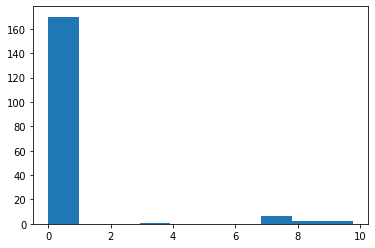

In [81]:
#those who aren't projected are a bunch of nobodies
x = detailed_projections[detailed_projections.name.isin(set(detailed_projections.name)-set(PROJECTIONS.keys()))]
plt.hist(x.fpts)

In [82]:
def lineup(choices, players):
    return [player for player in players if (choices[player].varValue == 1)]

In [83]:
def add_position_constraint(prob,choices, projections, position, constraint):
    sub_players = [player for player in projections if projections[player]['position'] == position]
    prob += lpSum([choices[v] for v in sub_players]) >= constraint

In [84]:
def add_flex_constraint(prob,choices,  projections):
    sub_players = [player for player in projections if projections[player]['position'] in ['RB', 'WR', 'TE']]
    prob += lpSum([choices[v] for v in sub_players]) == 7

In [85]:
def add_qb_wr_constraint(prob, choices, projections, team):
    goofy_list = []
    for player in projections:
        if projections[player]['position'] == 'QB' and projections[player]['team'] == team:
            goofy_list.append(1)
        elif projections[player]['position'] == 'WR' and projections[player]['team'] == team:
            goofy_list.append(-1)
        else: 
            goofy_list.append(0)
    prob += pulp.lpDot([choices[v] for v in projections], goofy_list) <=  0

In [87]:
def output_lineup(PROJECTIONS, detailed_projections):
    players = list(PROJECTIONS.keys())
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)
    for team in teams:
        add_qb_wr_constraint(prob,choices, PROJECTIONS, team)

    #objective function
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [PROJECTIONS[name]['points'] for name in players]), "Total Projection"
    prob.solve()
    print("expected ev is", value(prob.objective))
    print(lineup(choices, players))
    #print("total cost is", value(pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players])))
    return lineup(choices, players)

In [88]:
def opt_var(PROJECTIONS, detailed_projections):
    players = list(PROJECTIONS.keys())
    ceils  = detailed_projections[['name', 'ceil']].set_index('name')['ceil'].to_dict()
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)


    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [(ceils[name] - PROJECTIONS[name]['points']) if name in ceils else 0 for name in players ]), "Total Projection"
    prob.solve()
    return value(prob.objective)

In [89]:
def set_temp_variable(prob, choices, projections, team):
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    y = ["offense_"+team for team in teams]
    goofy_list = []
    for player in projections:
        if projections[player]['position'] != 'DST' and projections[player]['team'] == team:
            goofy_list.append(-1)
        else: 
            goofy_list.append(0)
    teams_variables = [100 if x == team else 0 for x in teams]
    prob += pulp.lpDot([choices[v] for v in projections]+ \
                       [choices[v] for v in y], goofy_list+teams_variables) >=  0
    prob += pulp.lpDot([choices[v] for v in projections] + \
                       [choices[v] for v in y], goofy_list+teams_variables) <=  99

In [90]:
def set_defense_constraints(prob, choices, projections):
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    for player in projections:
        if projections[player]['position'] == 'DST':
            opp = projections[player]['opp'].split()[-1]
            prob += choices[player] + choices["offense_"+opp] <= 1

In [91]:
opt_var(PROJECTIONS, detailed_projections)

116.41

In [96]:
def output_lineups(PROJECTIONS, detailed_projections, n = 10, dist = 3, hardcoded= {}):
    outputs = []
    
    ceils  = detailed_projections[['name', 'ceil']].set_index('name')['ceil'].to_dict()
    players = list(PROJECTIONS.keys())
    teams = set([PROJECTIONS[player]['team'] for player in PROJECTIONS])
    prob = pulp.LpProblem("NFL Maximizing EV", pulp.LpMaximize)
    
    temp_variables = ["offense_"+team for team in teams]
    print(temp_variables)
    choices = LpVariable.dicts("Choice", players+ temp_variables, cat='Binary')
    # 9 people to a team
    prob += lpSum([choices[v] for v in players]) == 9
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players]) <= 50001


    #adding in position constraints
    add_position_constraint(prob, choices, PROJECTIONS, 'QB', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'RB', 2)
    add_position_constraint(prob,choices, PROJECTIONS, 'WR', 3)
    add_position_constraint(prob,choices, PROJECTIONS, 'TE', 1)
    add_position_constraint(prob,choices, PROJECTIONS, 'DST', 1)
    add_flex_constraint(prob,choices, PROJECTIONS)
    
    #qb with at least one wide reciever
    for team in teams:
        add_qb_wr_constraint(prob,choices, PROJECTIONS, team)

    #add in variance optimization
    prob += pulp.lpDot([choices[v] for v in players],
                           [(ceils[name] - PROJECTIONS[name]['points']) if name in ceils else 0 for name in players ])\
                    >= .85*opt_var(PROJECTIONS, detailed_projections)
    
    #adding in no defense vs offense constraint
    for team in teams:
        set_temp_variable(prob, choices, PROJECTIONS, team)
    set_defense_constraints(prob, choices, PROJECTIONS)
    
    #adding in some hard-coded players
    for name in hardcoded:
        prob += choices[name] >= 1
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                           [PROJECTIONS[name]['points'] for name in players]), "Total Projection"
    prob.solve()
    outputs.append(lineup(choices, players))
    
    for i in range(n-1):
        prob += lpSum([choices[v] for v in players if choices[v].varValue == 1]) <= dist
        prob.solve()
        outputs.append(lineup(choices, players))
        print("expected ev is", value(prob.objective))
    #print("total cost is", value(pulp.lpDot([choices[v] for v in players],[PROJECTIONS[name]['salary'] for name in players])))
    return outputs

In [101]:
potential_lineups = output_lineups(PROJECTIONS, detailed_projections, dist = 3, n= 25)

['offense_BAL', 'offense_PHI', 'offense_CHI', 'offense_LAR', 'offense_IND', 'offense_DET', 'offense_JAC', 'offense_BUF', 'offense_KCC', 'offense_TEN', 'offense_CAR', 'offense_DAL', 'offense_NYJ', 'offense_SFO', 'offense_GBP', 'offense_LAC', 'offense_NYG', 'offense_PIT', 'offense_MIA', 'offense_HOU', 'offense_ATL', 'offense_MIN', 'offense_DEN', 'offense_WAS', 'offense_TBB', 'offense_ARI']
expected ev is 143.98000000000002
expected ev is 142.63
expected ev is 141.85000000000002
expected ev is 141.8
expected ev is 141.70000000000002
expected ev is 141.46999999999997
expected ev is 141.23
expected ev is 140.54
expected ev is 140.2
expected ev is 139.96
expected ev is 139.91
expected ev is 139.77
expected ev is 139.67
expected ev is 139.43
expected ev is 139.17000000000002
expected ev is 138.86
expected ev is 138.84
expected ev is 138.55
expected ev is 138.47000000000003
expected ev is 138.42000000000002
expected ev is 138.33
expected ev is 138.29999999999998
expected ev is 138.17
expected 

In [102]:
for team in potential_lineups:
    print("Team")
    for player in team:
        print(player, PROJECTIONS[player]['team'], PROJECTIONS[player]['position'],PROJECTIONS[player]['opp'])
    print()

Team
Kyler Murray ARI QB WAS
Chris Herndon NYJ TE SFO
Jonathan Taylor IND RB MIN
Corey Davis TEN WR JAC
Derrick Henry TEN RB JAC
Davante Adams GBP WR DET
Christian Kirk ARI WR WAS
Julio Jones ATL WR @ DAL
Buccaneers TBB DST CAR

Team
Dak Prescott DAL QB ATL
Chris Herndon NYJ TE SFO
Jonathan Taylor IND RB MIN
Derrick Henry TEN RB JAC
Parris Campbell IND WR MIN
CeeDee Lamb DAL WR ATL
Mike Evans TBB WR CAR
Ezekiel Elliott DAL RB ATL
Giants NYG DST @ CHI

Team
Dak Prescott DAL QB ATL
Chris Herndon NYJ TE SFO
Jonathan Taylor IND RB MIN
Breshad Perriman NYJ WR SFO
Davante Adams GBP WR DET
Kenyan Drake ARI RB WAS
Amari Cooper DAL WR ATL
Clyde Edwards-Helaire KCC RB @ LAC
Eagles PHI DST LAR

Team
Kyler Murray ARI QB WAS
Jonathan Taylor IND RB MIN
Breshad Perriman NYJ WR SFO
Derrick Henry TEN RB JAC
Parris Campbell IND WR MIN
Kenyan Drake ARI RB WAS
Mark Andrews BAL TE @ HOU
DeAndre Hopkins ARI WR WAS
Dolphins MIA DST BUF

Team
Kyler Murray ARI QB WAS
Chris Herndon NYJ TE SFO
Jonathan Taylor IN

In [106]:
ceils  = detailed_projections[['name', 'ceil']].set_index('name')['ceil'].to_dict()
for team in potential_lineups:
    best_case = sum([ceils[player] for player in team])
    print('ceil is', best_case)

ceil is 245.48999999999998
ceil is 243.40000000000003
ceil is 244.17999999999995
ceil is 242.59999999999997
ceil is 240.8
ceil is 241.44
ceil is 240.51
ceil is 241.81
ceil is 240.48999999999995
ceil is 239.22999999999996
ceil is 241.5
ceil is 239.04
ceil is 239.39000000000001
ceil is 238.76999999999995
ceil is 238.45999999999998
ceil is 239.24999999999997
ceil is 239.92
ceil is 238.44
ceil is 238.06999999999996
ceil is 237.92
ceil is 239.91000000000003
ceil is 237.42
ceil is 237.80999999999997
ceil is 237.59999999999997
ceil is 237.21999999999997
